In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !cp "drive/MyDrive/Question Generation/vae/models.py" .
%cd '/content/drive/MyDrive/Beta-HCVAE/vae/'
!pwd

/content/drive/MyDrive/Beta-HCVAE/vae
/content/drive/MyDrive/Beta-HCVAE/vae


In [ ]:
!nvcc --version

import torch
print("\nPytorch version: ", torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0

Pytorch version:  2.0.0+cu118


In [ ]:
!pip install -q transformers
!pip install -q json-lines
## scatter 1.12+cu113
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
# scatter 1.13+cu116
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.4 MB/s eta 0:00:00


In [ ]:
import argparse
import pickle

import torch
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import os
# from models import DiscreteVAE
from squad_utils import (InputFeatures,
                         read_examples,SquadExample,read_squad_examples,_improve_answer_span,_check_is_max_context,convert_examples_to_harv_features,convert_examples_to_features_answer_id)
from models import DiscreteVAE

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
def return_mask_lengths(ids):
    mask = torch.sign(ids).float()
    lengths = torch.sum(mask, 1).long()
    return mask, lengths


def post_process(q_ids, start_positions, end_positions, c_ids, total_max_len=384):
    """
       concatenate question and context for BERT QA model:
       [CLS] Question [SEP] Context [SEP]
    """
    batch_size = q_ids.size(0)
    # exclude CLS token in c_ids
    c_ids = c_ids[:, 1:]
    start_positions = start_positions - 1
    end_positions = end_positions - 1

    _, q_lengths = return_mask_lengths(q_ids)
    _, c_lengths = return_mask_lengths(c_ids)

    all_input_ids = []
    all_seg_ids = []
    for i in range(batch_size):
        q_length = q_lengths[i]
        c_length = c_lengths[i]
        q = q_ids[i, :q_length]  # exclude pad tokens
        c = c_ids[i, :c_length]  # exclude pad tokens


In [ ]:
def loadControlledDataset(args,chosen_q_type=None):  
    tokenizer = BertTokenizer.from_pretrained(args.bert_model)
    args.tokenizer = tokenizer

    device = torch.cuda.current_device()
    checkpoint = torch.load(args.checkpoint, map_location="cpu")
    vae = DiscreteVAE(checkpoint["args"])
    vae.load_state_dict(checkpoint["state_dict"])
    vae.eval()
    vae = vae.to(device)
    
    examples = read_squad_examples(args.file, is_training=True, debug=args.debug)
    indices = np.sort(np.random.choice(np.arange(len(examples)), min(len(examples),args.maxParaCount), replace=False))
    examples = [examples[i] for i in indices]
    features = convert_examples_to_features_answer_id(examples,
                                                      tokenizer=tokenizer,
                                                      max_seq_length=args.max_c_len,
                                                      max_query_length=args.max_q_len,
                                                      max_ans_length=args.max_q_len,
                                                      doc_stride=128,
                                                      is_training=True)

    all_c_ids = torch.tensor([f.c_ids for f in features], dtype=torch.long)
    all_qtype_ids = torch.tensor([f.qtype_ids if not chosen_q_type else chosen_q_type for f in features], dtype=torch.long)

    all_data = TensorDataset(all_c_ids,all_qtype_ids)
    data_loader = DataLoader(all_data, args.batch_size, shuffle=False)

    return data_loader, tokenizer, vae

In [ ]:
def loadDataset(args):  
    tokenizer = BertTokenizer.from_pretrained(args.bert_model)
    args.tokenizer = tokenizer

    device = torch.cuda.current_device()
    checkpoint = torch.load(args.checkpoint, map_location="cpu")
    vae = DiscreteVAE(checkpoint["args"])
    vae.load_state_dict(checkpoint["state_dict"])
    vae.eval()
    vae = vae.to(device)
    
    if args.generate:
        examples = read_squad_examples(args.data_file, is_training=True, debug=False)
        # chosen_ids = np.random.choice(np.arange(len(examples)),size=args.maxParaCount)
        # examples = [examples[i] for i in chosen_ids]
        features = convert_examples_to_harv_features(examples,
                                                     tokenizer=tokenizer,
                                                     max_seq_length=args.max_c_len,
                                                     max_query_length=args.max_q_len,
                                                     doc_stride=128,
                                                     is_training=True)
        all_c_ids = torch.tensor([f.c_ids for f in features], dtype=torch.long)
        data = TensorDataset(all_c_ids)
    else:
        examples = read_squad_examples(args.data_file, is_training=True, debug=False)
        features = convert_examples_to_features_answer_id(examples,
                                                          tokenizer=tokenizer,
                                                          max_seq_length=args.max_c_len,
                                                          max_query_length=args.max_q_len,
                                                          max_ans_length=args.max_q_len,
                                                          doc_stride=128,
                                                          is_training=True)
        

        all_c_ids = torch.tensor([f.c_ids for f in features], dtype=torch.long)
        all_q_ids = torch.tensor([f.q_ids for f in features], dtype=torch.long)
        all_tag_ids = torch.tensor([f.tag_ids for f in features], dtype=torch.long)
        all_a_ids = (all_tag_ids != 0).long()
        all_start_positions = torch.tensor([f.noq_start_position for f in features], dtype=torch.long)
        all_end_positions = torch.tensor([f.noq_end_position for f in features], dtype=torch.long)
        data = TensorDataset(all_c_ids, all_q_ids, all_a_ids, all_start_positions, all_end_positions)
    # indices = np.sort(np.random.choice(np.arange(len(features)), min(len(features),args.maxParaCount), replace=False))

    data_loader = DataLoader(data, shuffle=False, batch_size=args.batch_size)

    return data_loader, tokenizer, vae
def mainLoss(args,data_loader, tokenizer, vae):   
    running_q_rec = 0
    running_a_rec = 0
    running_zq_kl = 0
    running_za_kl = 0
    running_info_loss = 0
    for batch in tqdm(data_loader, total=len(data_loader)):
        c_ids = batch[0].to(device)
        q_ids = batch[1].to(device)
        a_ids = batch[2].to(device)
        start_positions = batch[3].to(device)
        end_positions = batch[4].to(device)
        

        with torch.no_grad():
            loss, loss_q_rec, loss_a_rec, loss_zq_kl, loss_za_kl, loss_info \
            = vae(c_ids, q_ids, a_ids, start_positions, end_positions, 1)

        running_q_rec += loss_q_rec
        running_a_rec += loss_a_rec
        running_zq_kl += loss_zq_kl
        running_za_kl += loss_za_kl
        running_info_loss += loss_info
                
    running_q_rec /= len(data_loader.dataset)
    running_a_rec /= len(data_loader.dataset)
    running_zq_kl /= len(data_loader.dataset)
    running_za_kl /= len(data_loader.dataset)
    running_info_loss /= len(data_loader.dataset)
    return running_q_rec,running_a_rec,running_zq_kl,running_za_kl,running_info_loss

def mainGenerate(args,data_loader, tokenizer, vae):   
    genPairs = list()

    for batch in tqdm(data_loader, total=len(data_loader)):
        c_ids = batch[0]
        _, c_len = return_mask_lengths(c_ids)
        max_c_len = torch.max(c_len)
        c_ids = c_ids[:, :max_c_len].to(device)
        
        # sample latent variable K times
        for _ in range(args.k):
            with torch.no_grad():
                _, _, zq, _, za = vae.prior_encoder(c_ids)
                batch_q_ids, batch_start, batch_end = vae.generate(zq, za, c_ids)
                
            for i in range(c_ids.size(0)):
                _c_ids = c_ids[i].cpu().tolist()
                q_ids = batch_q_ids[i].cpu().tolist()
                start_pos_a = batch_start[i].item()
                end_pos_a = batch_end[i].item()
                
                a_ids = _c_ids[start_pos_a: end_pos_a+1]
                c_text = tokenizer.decode(_c_ids, skip_special_tokens=True)
                q_text = tokenizer.decode(q_ids, skip_special_tokens=True)
                a_text = tokenizer.decode(a_ids, skip_special_tokens=True)
                json_dict = {
                    "context":c_text,
                    "question": q_text,
                    "answer": a_text,
                    "zq": zq[i].cpu().tolist(),
                    "za": za[i].cpu().tolist()
                }
                genPairs.append(json_dict)

    return genPairs

def mainControlled(args,data_loader, tokenizer, vae):   
    genPairs = list()

    for batch in tqdm(data_loader, total=len(data_loader)):
        c_ids = batch[0].to(device)
        qtype_ids = batch[1].to(device)
        
        # sample latent variable K times
        for _ in range(args.k):
            with torch.no_grad():
                _, _, zq, _, za = vae.prior_encoder(c_ids, qtype_ids)
                batch_q_ids, batch_start, batch_end = vae.generate(zq, za, c_ids, qtype_ids)
                
            for i in range(c_ids.size(0)):
                _c_ids = c_ids[i].cpu().tolist()
                q_ids = batch_q_ids[i].cpu().tolist()
                start_pos_a = batch_start[i].item()
                end_pos_a = batch_end[i].item()
                
                a_ids = _c_ids[start_pos_a: end_pos_a+1]
                c_text = tokenizer.decode(_c_ids, skip_special_tokens=True)
                q_text = tokenizer.decode(q_ids, skip_special_tokens=True)
                a_text = tokenizer.decode(a_ids, skip_special_tokens=True)
                json_dict = {
                    "context":c_text,
                    "question": q_text,
                    "answer": a_text,
                    "zq": zq[i].cpu().tolist(),
                    "za": za[i].cpu().tolist()
                }
                genPairs.append(json_dict)

    return genPairs

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def setArguments(dataFile, checkpoint, maxParaCount=float("inf"), seed=1004, bert_model="bert-base-uncased", max_length=384, batch_size=64, ratio=1, k = 1,generate=True):
    args = dict()
    args['maxParaCount'] = maxParaCount
    args['seed'] = seed
    args['generate'] = generate
    args['bert_model'] = bert_model
    args['max_length'] = max_length
    args['batch_size'] = batch_size
    args['data_file'] = dataFile
    args['checkpoint'] = checkpoint
    args['output_dir'] = "../data/synthetic_data/"
    args['ratio'] = ratio
    args['k'] = k
    args['max_c_len']=384
    args['max_q_len']=64
    args['squad'] = True
    
    return dotdict(args)    

In [ ]:
loss_dict = dict()
for beta in ["0_00","1_00","4_00", "50_00"]:
  checkpoint = f"../save/vae-checkpoint/best_f1_model{beta}.pt"
  args = setArguments(dataFile='../data/squad/my_test.json',k=1,generate=False,checkpoint=checkpoint)
  data_loader, tokenizer, vae = loadDataset(args)
  q_rec_loss,a_rec_loss,zq_kl_loss, za_kl_loss, info_loss = mainLoss(args,data_loader, tokenizer, vae)
  loss_dict[beta] = [q_rec_loss,a_rec_loss,zq_kl_loss, za_kl_loss, info_loss]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transfo

In [ ]:
import pickle
with open('../data/losses.pickle', 'wb') as f:
  pickle.dump(loss_dict, f)

{'0_00': [0.05079467222094536, 0.010167607106268406, 0.0003955551947001368, 0.11100482195615768, 0.0589984729886055], '1_00': [0.051873113960027695, 0.03805192932486534, 0.0001784835330909118, 0.04145240783691406, 0.04284335672855377], '4_00': [0.051927272230386734, 0.05900095775723457, 6.971221591811627e-05, 0.001619597664102912, 0.036976225674152374], '50_00': [0.05505675822496414, 0.06074605509638786, 1.953633272933075e-06, 2.2801129873073478e-08, 0.05337973311543465]}


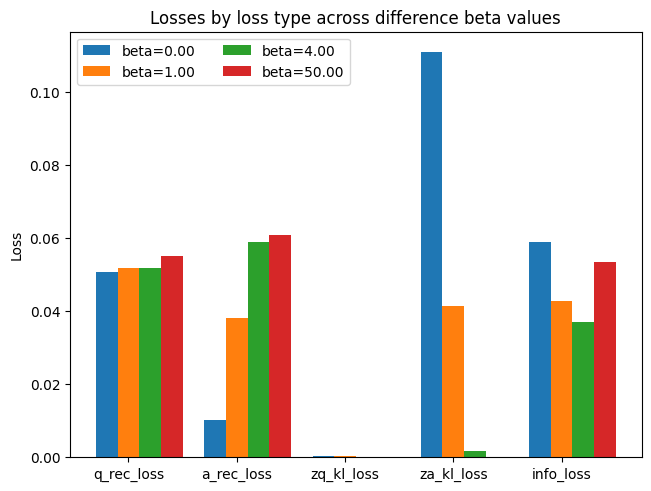

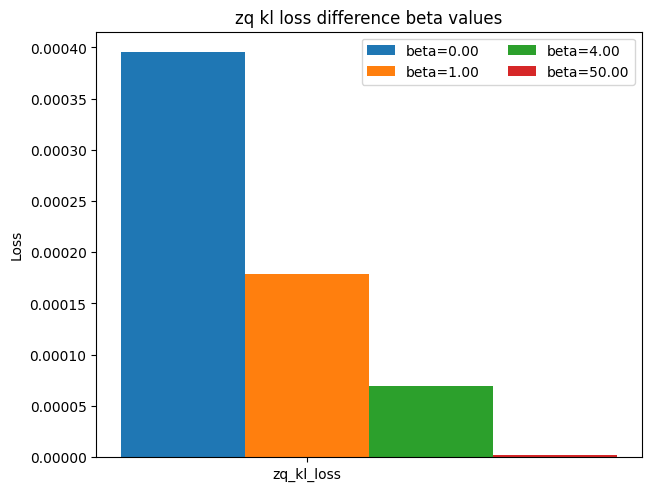

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
with open('../data/losses.pickle', 'rb') as f:
  loss_dict = pickle.load(f)

for key, value in loss_dict.items():
  loss_dict[key] = [val.item() for val in value]
  assert len(loss_dict[key]) == 5, key
labels = ['q_rec_loss','a_rec_loss','zq_kl_loss', 'za_kl_loss', 'info_loss']
print(loss_dict)
x = np.arange(5)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for beta_value, losses in loss_dict.items():
  offset = width*multiplier
  rects = ax.bar(x + offset, losses, width, label=f"beta={beta_value.replace('_','.')}")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Losses by loss type across difference beta values')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=2)

plt.show()

fig, ax = plt.subplots(layout='constrained')
labels = ['zq_kl_loss']
x = np.arange(1)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for beta_value, losses in loss_dict.items():
  offset = width*multiplier
  rects = ax.bar(x + offset, [losses[2]], width, label=f"beta={beta_value.replace('_','.')}")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('zq kl loss difference beta values')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper right', ncols=2)

plt.show()

In [ ]:
gen_dict = dict()
for beta in ["0_00","1_00","4_00", "50_00"]:
  checkpoint = f"../save/vae-checkpoint/best_f1_model{beta}.pt"
  args = setArguments(dataFile='../data/squad/my_test.json',k=1,generate=True,checkpoint=checkpoint)
  data_loader, tokenizer, vae = loadDataset(args)
  genPairs = mainGenerate(args,data_loader, tokenizer, vae)
  gen_dict[beta] = genPairs

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predic

In [ ]:
import pickle
with open('../data/gen_dict.pickle', 'wb') as f:
  pickle.dump(gen_dict, f)

In [ ]:
import pickle
with open('../data/gen_dict.pickle', 'wb') as f:
  pickle.dump(gen_dict, f)

In [ ]:
from google.colab import runtime
runtime.unassign()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5422 samples in 0.001s...
[t-SNE] Computed neighbors for 5422 samples in 0.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5422
[t-SNE] Computed conditional probabilities for sample 2000 / 5422
[t-SNE] Computed conditional probabilities for sample 3000 / 5422
[t-SNE] Computed conditional probabilities for sample 4000 / 5422
[t-SNE] Computed conditional probabilities for sample 5000 / 5422
[t-SNE] Computed conditional probabilities for sample 5422 / 5422
[t-SNE] Mean sigma: 0.298943
[t-SNE] KL divergence after 250 iterations with early exaggeration: 996.399658
[t-SNE] KL divergence after 1000 iterations: 4.164023


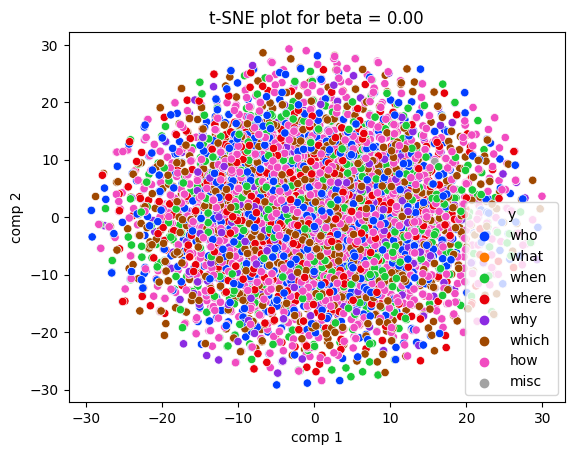

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5422 samples in 0.001s...
[t-SNE] Computed neighbors for 5422 samples in 0.575s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5422
[t-SNE] Computed conditional probabilities for sample 2000 / 5422
[t-SNE] Computed conditional probabilities for sample 3000 / 5422
[t-SNE] Computed conditional probabilities for sample 4000 / 5422
[t-SNE] Computed conditional probabilities for sample 5000 / 5422
[t-SNE] Computed conditional probabilities for sample 5422 / 5422
[t-SNE] Mean sigma: 0.281434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1029.856812
[t-SNE] KL divergence after 1000 iterations: 4.189150


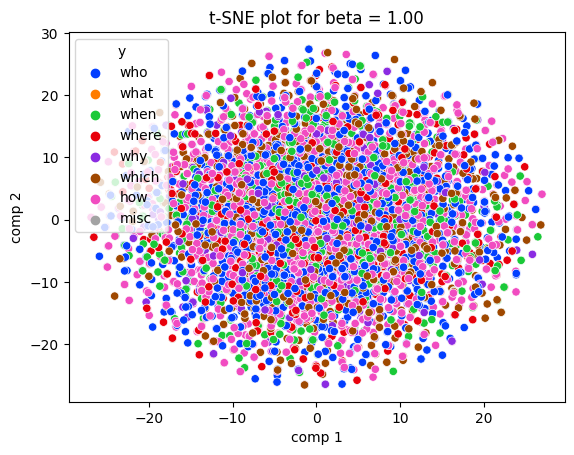

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5422 samples in 0.001s...
[t-SNE] Computed neighbors for 5422 samples in 0.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5422
[t-SNE] Computed conditional probabilities for sample 2000 / 5422
[t-SNE] Computed conditional probabilities for sample 3000 / 5422
[t-SNE] Computed conditional probabilities for sample 4000 / 5422
[t-SNE] Computed conditional probabilities for sample 5000 / 5422
[t-SNE] Computed conditional probabilities for sample 5422 / 5422
[t-SNE] Mean sigma: 0.417005
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1017.508667
[t-SNE] KL divergence after 1000 iterations: 4.191355


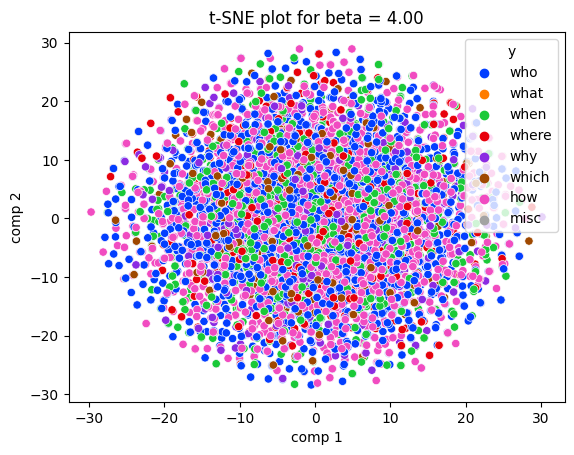

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5422 samples in 0.002s...
[t-SNE] Computed neighbors for 5422 samples in 0.324s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5422
[t-SNE] Computed conditional probabilities for sample 2000 / 5422
[t-SNE] Computed conditional probabilities for sample 3000 / 5422
[t-SNE] Computed conditional probabilities for sample 4000 / 5422
[t-SNE] Computed conditional probabilities for sample 5000 / 5422
[t-SNE] Computed conditional probabilities for sample 5422 / 5422
[t-SNE] Mean sigma: 0.780416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1004.278076
[t-SNE] KL divergence after 1000 iterations: 4.159680


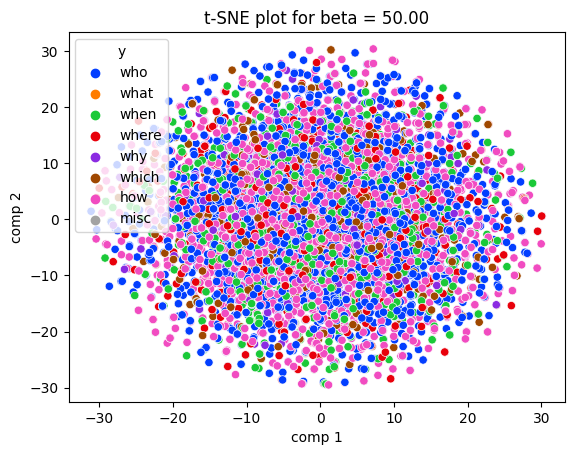

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

with open('../data/gen_dict.pickle', 'rb') as f:
  gen_dict = pickle.load(f)


for beta, genPairs in gen_dict.items():
    X = np.zeros((len(genPairs),50))
    y = []
    question_types = ['who', 'what', 'when', 'where', 'why', 'which', 'how']
    # print(type(genPairs[0]['za']))
    for i in range(len(genPairs)):
      X[i,:] = np.array(genPairs[i]['zq']).flatten()
      first_word = (genPairs[i]['question'].lower().split())[0]
      if first_word in question_types:
        y.append(first_word)
      else:
        y.append("misc")
    tsne = TSNE(n_components=2, verbose=1,early_exaggeration=100)
    tsne_results = tsne.fit_transform(X)
    df = pd.DataFrame()
    df['y'] = y 
    df['comp 1'] = tsne_results[:, 0]
    df['comp 2'] = tsne_results[:, 1]
    sns.scatterplot(x="comp 1", y="comp 2", hue='y',
                  data=df, hue_order=question_types+['misc'], palette = "bright").set(title=f"t-SNE plot for beta = {beta.replace('_','.')}")
    plt.savefig(f"../images/M6_tsne_beta{beta}.png")
    plt.show()

In [ ]:
!ls '..'

data  save  vae


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5422 samples in 0.001s...
[t-SNE] Computed neighbors for 5422 samples in 0.628s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5422
[t-SNE] Computed conditional probabilities for sample 2000 / 5422
[t-SNE] Computed conditional probabilities for sample 3000 / 5422
[t-SNE] Computed conditional probabilities for sample 4000 / 5422
[t-SNE] Computed conditional probabilities for sample 5000 / 5422
[t-SNE] Computed conditional probabilities for sample 5422 / 5422
[t-SNE] Mean sigma: 0.191806
[t-SNE] KL divergence after 250 iterations with early exaggeration: 944.604126
[t-SNE] KL divergence after 1000 iterations: 2.743150


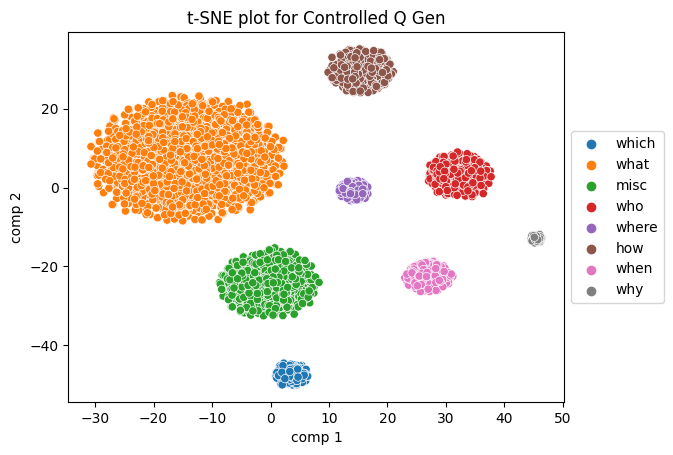

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  
with open('../data/gen_controlled_list.pickle', 'rb') as f:
  genPairs = pickle.load(f)

X = np.zeros((len(genPairs),50))
y = []
question_types = ['who', 'what', 'when', 'where', 'why', 'which', 'how']
# print(type(genPairs[0]['za']))
for i in range(len(genPairs)):
  X[i,:] = np.array(genPairs[i]['zq']).flatten()
  first_word = (genPairs[i]['question'].lower().split())[0]
  if first_word in question_types:
    y.append(first_word)
  else:
    y.append("misc")
tsne = TSNE(n_components=2, verbose=1,early_exaggeration=100)
tsne_results = tsne.fit_transform(X)
df = pd.DataFrame()
df['y'] = y 
df['comp 1'] = tsne_results[:, 0]
df['comp 2'] = tsne_results[:, 1]
g = sns.scatterplot(x="comp 1", y="comp 2", hue='y',
              data=df)
g.set(title=f"t-SNE plot for Controlled Q Gen")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.savefig(f"../images/M6_controlled_gen.png", format="png")
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 832 samples in 0.000s...
[t-SNE] Computed neighbors for 832 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 832 / 832
[t-SNE] Mean sigma: 0.265648
[t-SNE] KL divergence after 250 iterations with early exaggeration: 806.721191
[t-SNE] KL divergence after 1000 iterations: 0.799001


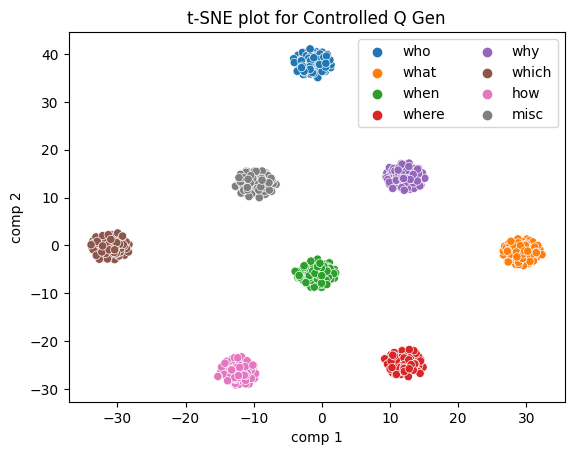

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  
with open('../data/gen_controlled_list2.pickle', 'rb') as f:
  genPairs = pickle.load(f)

X = np.zeros((len(genPairs),50))
y = []
question_types = ['who', 'what', 'when', 'where', 'why', 'which', 'how']
for i in range(len(genPairs)):
  X[i,:] = np.array(genPairs[i]['zq']).flatten()
  first_word = (genPairs[i]['question'].lower().split())[0]
  if first_word in question_types:
    y.append(first_word)
  else:
    y.append("misc")
tsne = TSNE(n_components=2, verbose=1,early_exaggeration=100)
tsne_results = tsne.fit_transform(X)
df = pd.DataFrame()
df['y'] = y 
df['comp 1'] = tsne_results[:, 0]
df['comp 2'] = tsne_results[:, 1]
g = sns.scatterplot(x="comp 1", y="comp 2", hue='y',
              data=df)
g.set(title=f"t-SNE plot for Controlled Q Gen")
g.legend(loc='upper right', ncol=2)#, bbox_to_anchor=(1, 0.5), ncol=1)
plt.savefig(f"../images/M6_normalised_controlled_gen.png", format="png")
plt.show()

In [ ]:
from sklearn.metrics import f1_score
import collections
from collections import Counter
all_qtypes = ['who', 'what', 'when', 'where', 'why', 'which', 'how']
with open('../data/gen_dict.pickle', 'rb') as f:
  gen_dict = pickle.load(f)
pred_dict = dict()
for beta, genPairs in gen_dict.items():
  predicted_labels = []
  accuracy = 0
  print(len(genPairs))
  for genInfo in genPairs:
    predicted_type = genInfo['question'].lower().split()[0]
    if predicted_type not in all_qtypes:
      predicted_type = 'misc'
    predicted_labels.append(predicted_type)
  labelCounts = Counter(predicted_labels)
  
  if 'misc' not in labelCounts:
    labelCounts['misc'] = 0
  if 'what' not in labelCounts:
    labelCounts['what'] = 0
  pred_dict[beta] = labelCounts
  labelCounts = collections.OrderedDict(sorted(labelCounts.items()))
  print(beta, pred_dict[beta])

5422
0_00 Counter({'how': 1686, 'which': 1026, 'who': 1017, 'when': 714, 'where': 653, 'why': 324, 'misc': 2, 'what': 0})
5422
1_00 Counter({'how': 1622, 'who': 1440, 'which': 785, 'when': 722, 'where': 586, 'why': 267, 'misc': 0, 'what': 0})
5422
4_00 Counter({'who': 1855, 'how': 1779, 'when': 764, 'why': 380, 'where': 367, 'which': 277, 'misc': 0, 'what': 0})
5422
50_00 Counter({'who': 1869, 'how': 1745, 'when': 716, 'where': 515, 'which': 403, 'why': 174, 'misc': 0, 'what': 0})


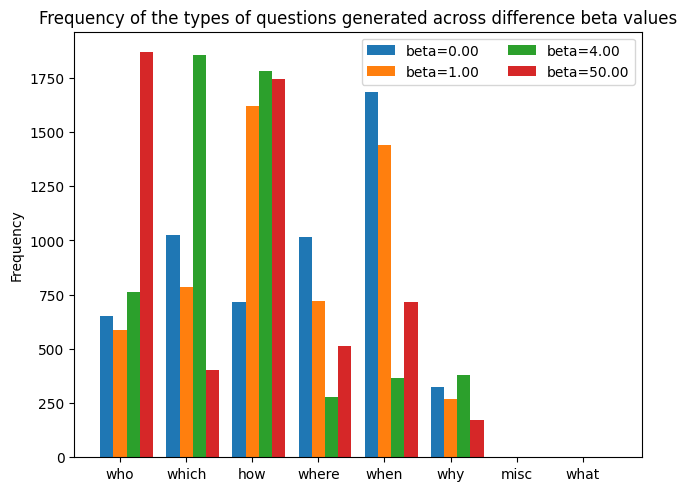

In [ ]:
fig, ax = plt.subplots(layout='constrained')
x = np.arange(8)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for beta_value, prediction_counts in pred_dict.items():
  offset = width*multiplier
  rects = ax.bar(x + offset, prediction_counts.values(), width, label=f"beta={beta_value.replace('_','.')}")
  multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Frequency of the types of questions generated across difference beta values')
ax.set_xticks(x + width, prediction_counts.keys())
ax.legend(loc='upper right', ncols=2)
plt.savefig(f"../images/M6_qgen_counts_by_beta.svg", format="svg")
plt.show()

In [ ]:
import pickle
with open('../data/gen_controlled_list.pickle', 'rb') as f:
  genPairs = pickle.load(f)

In [ ]:
from sklearn.metrics import f1_score
all_qtypes = ['who', 'what', 'when', 'where', 'why', 'which', 'how']
predicted_labels = []
ground_truth_labels = []
accuracy = 0
print(len(genPairs))
for genInfo in genPairs:
  desired_qtype = list(genInfo['q_vector'])
  index = desired_qtype.index(1)
  if index < len(all_qtypes):
    gt_type = all_qtypes[index]
  else:
    gt_type = 'misc'
    
  ground_truth_labels.append(gt_type)
  predicted_type = genInfo['question'].lower().split()[0]
  if predicted_type not in all_qtypes:
    predicted_type = 'misc'
  predicted_labels.append(predicted_type)
  if gt_type != predicted_type:
    print(gt_type, predicted_type, genInfo['q_vector'], genInfo['question'])
    
f1_scores = f1_score(ground_truth_labels, predicted_labels, average=None, labels=all_qtypes+['misc'])
f1_scores_with_labels = {label:score for label,score in zip(all_qtypes+['misc'], f1_scores)}

5422
who what (1, 0, 0, 0, 0, 0, 0, 0) what was the first superard that was forced to recapture for the olympics?
which what (0, 0, 0, 0, 0, 1, 0, 0) what was the average for a 30 second - second secattre?


In [ ]:
f1_scores_with_labels

{'who': 0.999071494893222,
 'what': 0.9996056782334385,
 'when': 1.0,
 'where': 1.0,
 'why': 1.0,
 'which': 0.9977924944812362,
 'how': 1.0,
 'misc': 1.0}

In [ ]:
import numpy as np
(np.array(predicted_labels)!=np.array(ground_truth_labels)).sum()

2

In [ ]:
# X = np.zeros((len(genPairs),50))
# y = []
# question_types = ['when','which','where','why','how','when']
# # print(type(genPairs[0]['za']))
# for i in range(len(genPairs)):
#   X[i,:] = np.array(genPairs[i]['zq']).flatten()
#   first_word = (genPairs[i]['question'].lower().split())[0]
#   if first_word in question_types:
#     y.append(first_word)
#   else:
#     y.append("misc")

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
tsne = TSNE(n_components=3, verbose=1,early_exaggeration=100)
tsne_results = tsne.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5422 samples in 0.001s...
[t-SNE] Computed neighbors for 5422 samples in 1.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5422
[t-SNE] Computed conditional probabilities for sample 2000 / 5422
[t-SNE] Computed conditional probabilities for sample 3000 / 5422
[t-SNE] Computed conditional probabilities for sample 4000 / 5422
[t-SNE] Computed conditional probabilities for sample 5000 / 5422
[t-SNE] Computed conditional probabilities for sample 5422 / 5422
[t-SNE] Mean sigma: 0.779851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1692.700562
[t-SNE] KL divergence after 1000 iterations: 6.361387


In [ ]:
# visualize
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2', 'comp3'])
df_tsne['label'] = y
fig = px.scatter_3d(
    df_tsne, x='comp1', y='comp2', z='comp3',
    color=df_tsne.label, labels={'color': 'label'}
)
fig.update_traces(marker_size=2)
fig.show()
# sns.lmplot(x='comp1', y='comp2', data=df_tsne, fit_reg=False,  hue='label')